# Assignment #3

### Group 4

Lars Wrede, Dennis Blaufuss, Nicolas Kepper, Sophie Merl, Philipp Voit
___

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import matplotlib as mpl
from mpl_toolkits import mplot3d
import random as rd
import math
from scipy.stats import norm
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

___
## Expectation-Maximization (EM) 
Implement for a useful nontrivial use case of your choice the EM Algorithm
(__two Gaussians__),
surrogate data creation included. Nice documentation, commenting, presentations, take homes and animations are welcome.

___

In statistical inference, we want to find the best model parameters given the observed data. In the frequentist view, we want to maximize the MLE. In bayesian inference, this is done by maximizing the posterior distribution.

However, what if there are latent variables? In this case we would need to use EM.

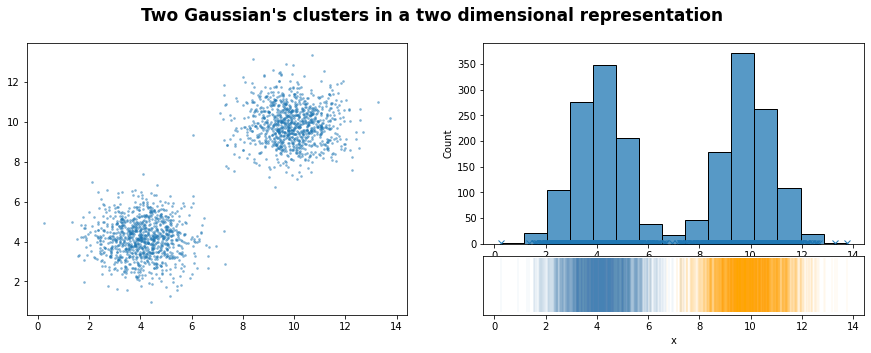

In [2]:
def gaus_data(k=2, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random Gaussian in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    # returns a randomly drawn mean in a range from -10 to 10.
    mean = np.random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]   
    for i in range(k):
        # returns a randomly drawn std in a range from 1 to 3.
        sigma = np.random.randint(low = 1, high = 3) 
        _x = np.random.normal(mean[i][0], sigma, size = (points_per_cluster, 2))
        x += list(_x)
        # saves the latent variables - WILL NOT BE USED LATER
        if i == 0: 
            x1 = _x
        if i == 1:
            x2 = _x
    x = np.array(x)
    if(dim == 2):
        fig = plt.figure(figsize=(15, 5)) #Plot size
        fig.suptitle("Two Gaussian's clusters in a two dimensional representation",
                     fontsize = 17, fontweight = "bold")
        '''First Plot - Scatterplot'''
        ax = plt.subplot2grid(shape = (4, 2), loc = (0, 0), rowspan = 4)
        ax.scatter(x[:,0], x[:, 1], s = 3, alpha = 0.4)
        ax.autoscale(enable = True)
        
        '''Second Plot - Histogram'''
        ax = plt.subplot2grid(shape = (4, 2), loc = (0, 1), rowspan = 3)
        sns.histplot(x=x[:, 0])
        ax.plot(x[:, 0], len(x[:, 0]) * [1], "x")
        ax.autoscale(enable = True)
        
        '''Third Plot - Visualization of latent variables'''
        ax = plt.subplot2grid(shape = (4, 2), loc = (3, 1), rowspan = 1)
        ax.vlines(x1, 0, 0.01, color = 'orange', alpha = 0.05);
        ax.vlines(x2, 0, 0.01, color = 'steelblue', alpha = 0.05);
        ax.set_yticks([]);
        ax.set_xlabel('x');
    return x[:,0], x1, x2
x, x1, x2 = gaus_data(k = 2, dim = 2, points_per_cluster=1000)

We would like to model the density of the data points (1D), and due to the apparent bi-modality, one Gaussian distribution would not be appropriate. In acc. with the histogram on the right, there seems to be two separate underlying regimes, so instead we model $Z$ as a mixture of two Gaussian's.

For visualization purposes we also generated $Z$ (which Gaussian the data came from). The orange and blue vlines represent the two clusters.

We will now continue to implement the EM algorithmus for the two Gaussian's in one dimension.

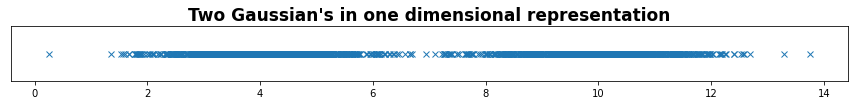

In [3]:
fig = plt.figure(figsize=(15,1))
plt.plot(x, len(x) * [1], "x")
plt.title("Two Gaussian's in one dimensional representation",
          fontsize = 17, fontweight = "bold")
plt.yticks([])
plt.show()

Parameters: $\mu_a, \mu_b, \sigma_a, \sigma_b, \pi$ (Switching Parameter)

Probability given x for b?

$$P(b|x_i)=\frac{P(x_i|b)*P(b)}{P(x_i|a)*P(a) + P(x_i|b)*P(b)}$$

where: $P(x_i|b)=\frac{1}{\sqrt{2\bar{\pi}\sigma_b^2}}*e^{-\frac{(x_i-\mu_b)^2}{2\sigma_b^2}}$, 
$P(x_i|a)=\frac{1}{\sqrt{2\bar{\pi}\sigma_a^2}}*e^{-\frac{(x_i-\mu_a)^2}{2\sigma_a^2}}$,
$P(b)=\frac{1}{n}\sum b_i$, $P(a) = 1-P(b)$

We update $\mu$ and $\sigma$ as following:

$\mu_b:=\frac{\sum b_i*x_i}{\sum b_i}$, $\mu_a:=\frac{\sum a_i*x_i}{\sum a_i}$, $\sigma^2_b:=\frac{\sum b_i*(x_i -\mu_b)^2}{\sum b_i}$, $\sigma^2_a:=\frac{\sum a_i*(x_i -\mu_a)^2}{\sum a_i}$

In [4]:
def prob_xi_given_a_b(sigma2, x, mu):
    prob_xi_b = ( 1 / math.sqrt(2 * prob_b * sigma2)) * math.exp(-1*((x-mu)**2 / 2*sigma2))
    return prob_xi_b

def estimate_sigma2(member, x, mu):
    numerator = 0
    denominator = 0
    for i, m_value in enumerate(member):
        numerator += (m_value * ((x[i] - mu)**2))
        denominator += m_value
    sigma_2 = np.divide(numerator, denominator)
    sigma_2 = np.where(np.isnan(sigma_2), 0, sigma_2)
    return sigma_2

def estimate_mu(member, x):
    numerator = 0
    denominator = 0
    for i, m_value in enumerate(member):
        numerator += (m_value * x[i])
        denominator += m_value
        mu = np.divide(numerator, denominator)
        mu = np.where(np.isnan(mu), 0, mu)
    return mu

def prob_b_given_xi(sigma2_a, sigma2_b, x, mu_a, mu_b):
    
    prob_xi_b = prob_xi_given_a_b(sigma2_b, x, mu_b)
    prob_xi_a = prob_xi_given_a_b(sigma2_a, x, mu_a)
    
    bi = np.divide((prob_xi_b * prob_b), ((prob_xi_b * prob_b) + (prob_xi_a * prob_a)))
    bi = np.where(np.isnan(bi), 0, bi)
    return bi # ai = 1-bi

def gaussian(x, mu, sigma) :
    gaus = np.exp(-np.power(x-mu, 2) / (2*np.power(sigma, 2)))
    return gaus

def plot_distributions(x, g1_mu, g1_si, g2_mu, g2_si, mu_a, mu_b, sigma_a, sigma_b):
    fig, ax = plt.subplots(figsize=(15, 3))
    affine1d = np.linspace(min(x), max(x), 150)
    ax.plot(affine1d, gaussian(affine1d, g1_mu, g1_si), c='b', 
            label = "True Distribution")
    ax.plot(affine1d, gaussian(affine1d, g2_mu, g2_si), c='b')
    ax.plot(affine1d, gaussian(affine1d, mu_a, sigma_a), c='y', 
            label = "Estimated Distribution")
    ax.plot(affine1d, gaussian(affine1d, mu_b, sigma_b), c='y')
    ax.legend()
    plt.show()

A good way to constract initial guesses for $\mu_1$  and $\mu_2$ is simply to choose two of the $x_i$ at random. We can set $\sigma_1^2$ and $\sigma_2^2$ equal to the overall sample variance $\sum^{N}_{i=1}(x_i-\bar{x})^2/N$. The mixing proportion $\bar{\pi}$ can be started at the value 0.5.

In [5]:
# Mixing Proportion for the first run.
prob_a = 0.5
prob_b = 0.5

def expectation_maximization(x, iterationen = 5):
    sigma2_a = (rd.choice(x)-np.mean(x))**2/len(x)
    sigma2_b = (rd.choice(x)-np.mean(x))**2/len(x)
    mu_a = rd.choice(x)
    mu_b = rd.choice(x)

    for iteration in range(0, iterationen):
        member_a = []
        member_b = []

        plot_distributions(x,
                           np.mean(x1[:,0]), np.std(x1[:,0]), 
                           np.mean(x2[:,0]), np.std(x2[:,0]),
                           mu_a, mu_b, 
                           math.sqrt(sigma2_a), math.sqrt(sigma2_b))
        print(f"Iteration: {str(iteration+1)}")
        
        # Calculates the Probabilities of xi beeing either in distribution A or B.
        for i in range(0, len(x)): 
            xi = x[i]
            bi = prob_b_given_xi(sigma2_a, sigma2_b, xi, mu_a, mu_b)
            member_b.append(bi)
            member_a.append(1 - bi) # ai + bi = 1
        
        # Reestimation of mu, sigma and the mixing proportion.
        mu_b = estimate_mu(member_b, x) 
        sigma2_b = estimate_sigma2(member_b, x, mu_b)

        mu_a = estimate_mu(member_a, x)
        sigma2_a = estimate_sigma2(member_a, x, mu_a)

        prob_b = np.sum(member_b)/len(member_b)
        prob_a = 1-prob_b

    plot_distributions(x, # We need this plot for the last Iteration
                       np.mean(x1[:,0]), np.std(x1[:,0]), 
                       np.mean(x2[:,0]), np.std(x2[:,0]),
                       mu_a, mu_b, 
                       math.sqrt(sigma2_a), math.sqrt(sigma2_b))
    
    return mu_a, math.sqrt(sigma2_a), mu_b, math.sqrt(sigma2_b), prob_b

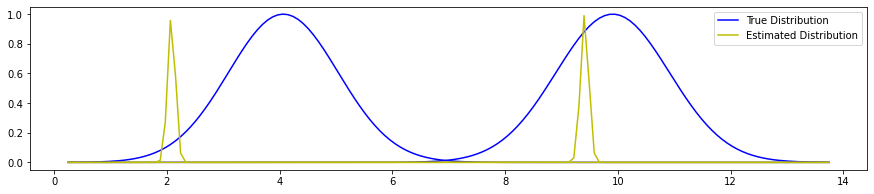

Iteration: 1


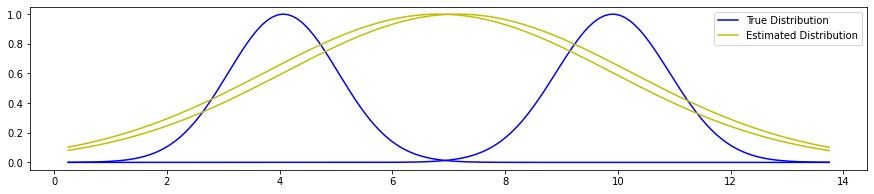

Iteration: 2


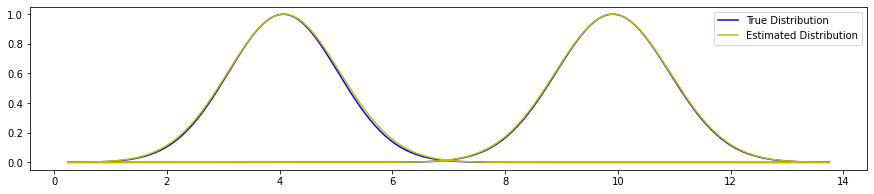

Iteration: 3


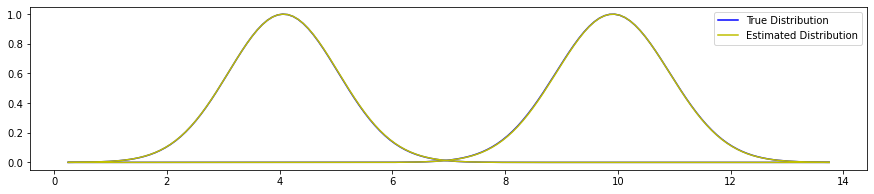

Iteration: 4


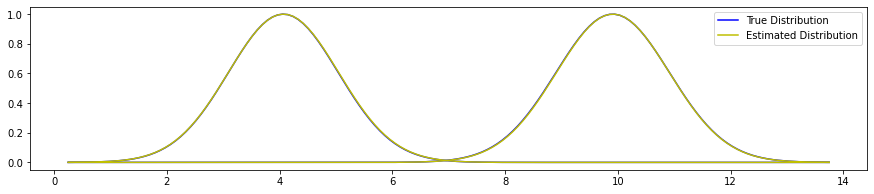

Iteration: 5


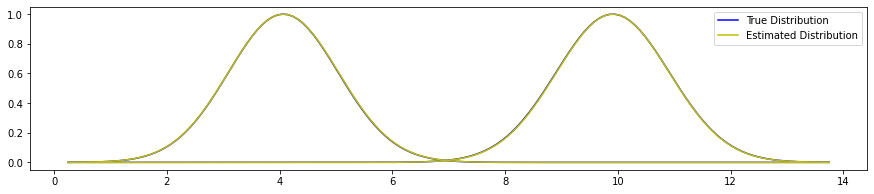

In [6]:
mu_a, sigma2_a, mu_b, sigma2_b, prob_b = expectation_maximization(x)

The final maximum likelihood estimates are:

$\bar{\mu}_1$

In [7]:
mu_a

array(9.91153061)

$\bar{\mu}_2$

In [8]:
mu_b

array(4.06885469)

$\bar{\sigma}_1^2$

In [9]:
sigma2_a

1.0013154876761836

$\bar{\sigma}_2^2$

In [10]:
sigma2_b

0.9774198683922655

$\bar{\pi_b}$

In [11]:
prob_b

0.5004645054031641

#### Take Home Message:
After running the EM-algorithmus 5 times, the EM-algorithmus is able to give us a pretty good idea where the two underlying Gaussian's are. We also expected $\bar{\pi_b}$ to stay around 0.5 because the two generated Gaussian's both have the same sample size and $\sigma$. Overall, the more segregated the two distribution are, the better are our estimates.
___

Sometimes the EM-algorithmus can get stuck on local minimas, on sattle points or when the underlying distributions are too overlapping. An example of this can be seen here:

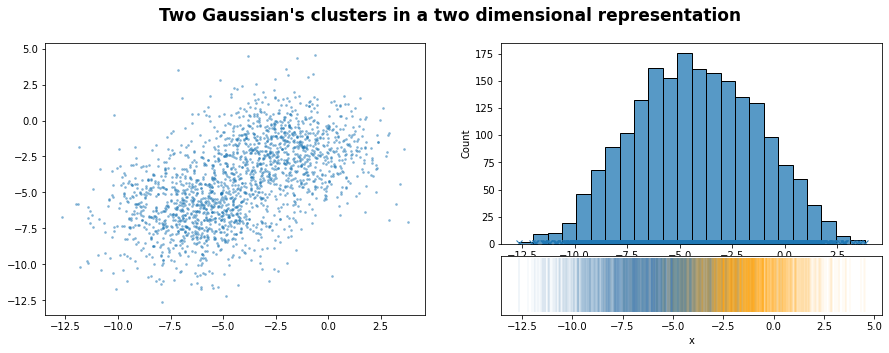

In [95]:
x, x1, x2 = gaus_data(k = 2, dim = 2, points_per_cluster=1000)

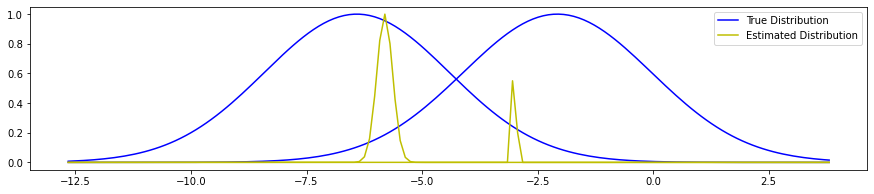

Iteration: 1


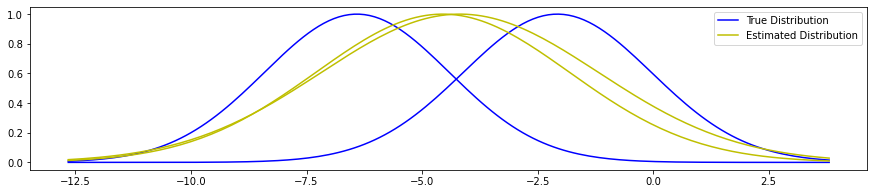

Iteration: 2


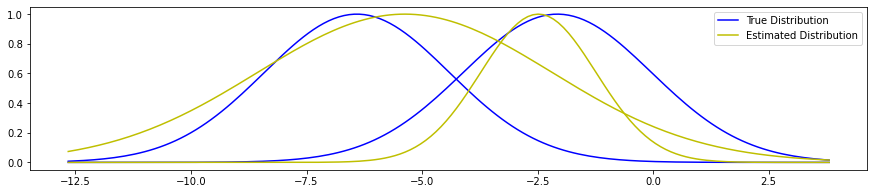

Iteration: 3


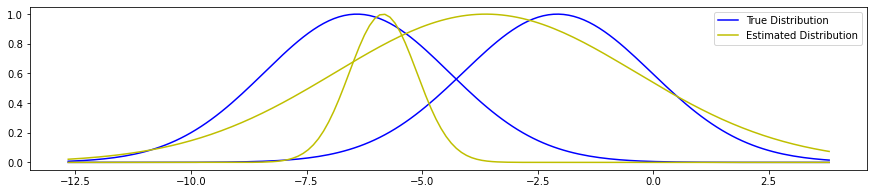

Iteration: 4


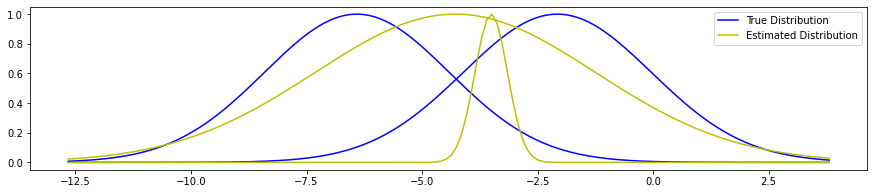

Iteration: 5


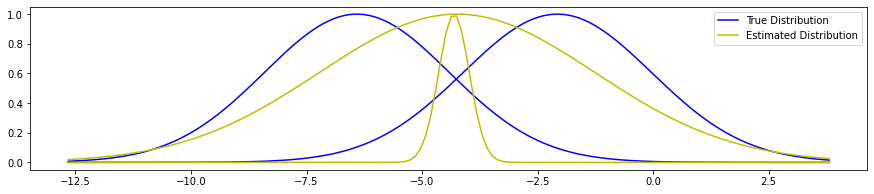

In [96]:
mu_a, sigma2_a, mu_b, sigma2_b, prob_b = expectation_maximization(x)